Acceptance Rate: 0.356849730578


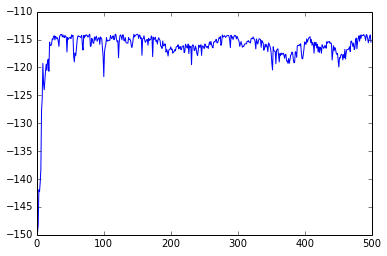

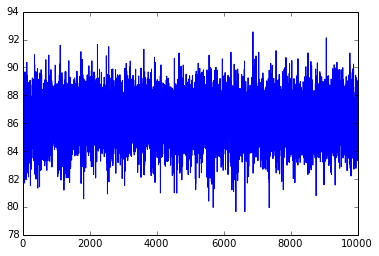

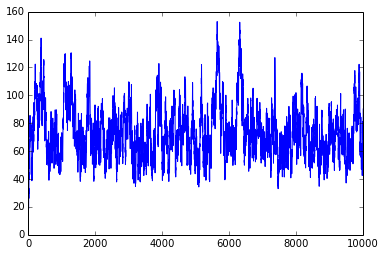

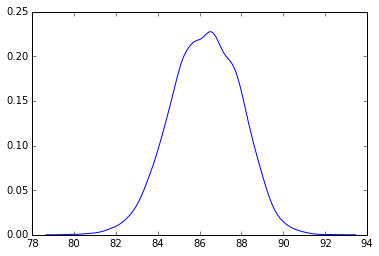

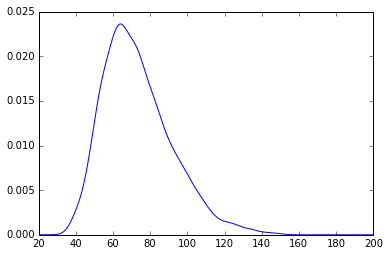

In [29]:
%matplotlib inline
import numpy as np
from math import sqrt, exp, log
import scipy.stats as st
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

scores = np.loadtxt('examscores.csv')
# initialize the hyperparameters
alpha = 3
beta = 50
mu0 = 80
sig20 = 16
# initialize the prior distributions
muprior = st.norm(loc=mu0, scale=sqrt(sig20))
sig2prior = st.invgamma(alpha,scale=beta)
# define the proposal function
def proposal(y, s):
 res = np.zeros(len(y))
 for i in xrange(len(y)):
     res[i] = st.norm.rvs(y[i], scale=sqrt(s))
 return res

# define the log of the proportional density
def propLogDensity(x):
 return muprior.logpdf(x[0])+sig2prior.logpdf(x[1])+st.norm.logpdf(scores,loc=x[0],scale=sqrt(x[1])).sum()

def metropolis(x0, s, n_samples):
    """
    Use the Metropolis algorithm to sample from posterior.
    Parameters
    ----------
    x0 : ndarray of shape (2,)
    The first entry is mu, the second entry is sigma2
    s : float > 0
    The standard deviation parameter for the proposal function
    n_samples : int
    The number of samples to generate
    Returns
    -------
    draws : ndarray of shape (n_samples, 2)
    The MCMC samples
    logprobs : ndarray of shape (n_samples)
    The log density of the samples
    accept_rate : float
    The proportion of proposed samples that were accepted
    """
    accept_counter = 0
    total = 0
    draws = np.empty((n_samples,2))
    logprob = np.empty(n_samples)
    x = x0.copy()
    while accept_counter < n_samples:
        total += 1
        xprime = proposal(x,s)
        u = np.random.rand(1)[0] + 1e-10
        if log(u) <= propLogDensity(xprime) - propLogDensity(x):
            x = xprime
            draws[accept_counter] = x
            logprob[accept_counter] = propLogDensity(x)
            accept_counter += 1

    return draws, logprob, accept_counter/float(total)

draws, lprobs, rate = metropolis(np.array([80., 10.]), 20., 10000)
print "Acceptance Rate:", rate

# plot the first 500 log probs
plt.plot(lprobs[:500])
plt.show()
# plot the mu samples
plt.plot(draws[:,0])
plt.show()
# plot the sigma2 samples
plt.plot(draws[:,1])
plt.show()
# build and plot KDE for posterior mu
mu_kernel = gaussian_kde(draws[50:,0])
x_min = min(draws[50:,0]) - 1
x_max = max(draws[50:,0]) + 1
x = np.arange(x_min, x_max, step=0.1)
plt.plot(x,mu_kernel(x))
plt.show()
# build and plot KDE for posterior sigma2
sig_kernel = gaussian_kde(draws[50:,1])
x_min = 20
x_max = 200
x = np.arange(x_min, x_max, step=0.1)
plt.plot(x,sig_kernel(x))
plt.show()


A function to create random Ising configurations, along with a sample random configuration.

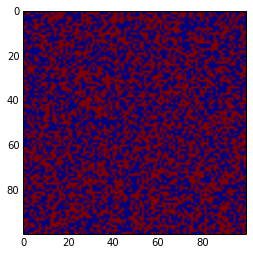

In [40]:
def random_config(N=100):
    return 2 * (np.random.random_integers(0,1,(N,N))) - 1

plt.imshow(random_config())
plt.show()

A function to compute the energy of a spin configuration.

In [44]:
def energy(config):
    N = config.shape[0]
    H = np.sum(config[:N-1,:] * config[1:,:])
    H += np.dot(config[0,:], config[-1, :])
    H += np.sum(config[:,:N-1] * config[:,1:])
    H += np.dot(config[:,0], config[:, -1])
    return -H
print energy(random_config())

-76


It is now time to apply the Metropolis Algorithm to create the distribution of spin configurations!

In [87]:
def rand_inds(N=100):
     return np.random.randint(N), np.random.randint(N)

def update_energy(C, i,j, curr_energy):
    N = C.shape[0]
    return curr_energy + C[i,j] * ( C[(i+1)%N, j] + C[i, (j+1)%N] + C[i, j-1] + C[i-1, j])

def accept_sample(curr_energy, prop_energy, beta):
    u = np.random.random(1)[0]
    return log(u) < min(0, beta * (curr_energy - prop_energy))
    
def ising_metro(beta, n_samples = 200000, sample_rate = 4000, burnin = 100, N=100):
    logprobs = np.empty(burnin+n_samples)
    config = random_config(N)
    curr_energy = energy(config)
    samples = np.empty((n_samples/sample_rate, config.shape[0], config.shape[1]))
    i,j = 0,0
    while i < burnin:
        ind1, ind2 = rand_inds(N)
        prop_energy = update_energy(config, ind1, ind2, curr_energy)
        if accept_sample(curr_energy, prop_energy, beta):
            logprobs[i] =  - beta * prop_energy
            curr_energy = prop_energy
            config[ind1, ind2] *= -1
            i += 1
    
    while j < n_samples:
        ind1, ind2 = rand_inds(N)
        prop_energy = update_energy(config, ind1, ind2, curr_energy)
        if not accept_sample(curr_energy, prop_energy, beta): continue
        logprobs[burnin+j] =  - beta * prop_energy
        curr_energy = prop_energy
        config[ind1, ind2] *= -1
        j += 1
        if j % sample_rate == 0:
            samples[j/sample_rate-1,:,:] = config.copy()
            
    return samples, logprobs



Having coded the Metropolis algorithm, we test to see if it actually works.

In [ ]:
def test_ising(beta):
    print "Beta = %f" % beta
    print
    samples, lprobs = ising_metro(beta, n_samples=200000)
    plt.subplot(121)
    plt.imshow(samples[-1, :, :])
    plt.title("Sample Configuration")
    plt.subplot(122)
    plt.plot(lprobs)
    plt.title("Log Probability")
    plt.subplots_adjust(right=2., hspace=.1)
    plt.show()

test_ising(1)
test_ising(.2)


As desired, when beta is 1, the final coniguration has a higher degree of structure.